In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler


city_stats_df = pd.read_csv('/content/drive/MyDrive/Project/Datasets/MSW_Waste_59_Cities.csv')
waste_df = pd.read_csv('/content/drive/MyDrive/Project/Datasets/Waste_Management_and_Recycling_India.csv')
new_pop_df = pd.read_csv('/content/drive/MyDrive/Project/Datasets/cities_r2.csv')  # Your new population dataset
sdg_df = pd.read_csv('/content/drive/MyDrive/Project/Datasets/Data_SDG_India_Index_2020-21.csv')
population_df = pd.read_csv('/content/drive/MyDrive/Project/Datasets/Area_Population_Density_and_Population_2011_Census.csv')



In [ ]:
# Save raw datasets before preprocessing
waste_df.to_csv('/content/drive/MyDrive/Project/Dataset/backup_waste_raw.csv', index=False)
population_df.to_csv('/content/drive/MyDrive/Project/Dataset/backup_population_raw.csv', index=False)
city_stats_df.to_csv('/content/drive/MyDrive/Project/Dataset/backup_city_stats_raw.csv', index=False)
new_pop_df.to_csv('/content/drive/MyDrive/Project/Dataset/backup_new_pop_raw.csv', index=False)
sdg_df.to_csv('/content/drive/MyDrive/Project/Dataset/backup_sdg_raw.csv', index=False)



# Optionally display heads to verify in notebook
print("Raw waste_df snapshot:")
print(waste_df.head())



Raw waste_df snapshot:
  City/District    Waste Type  Waste Generated (Tons/Day)  Recycling Rate (%)  \
0        Mumbai       Plastic                        6610                  68   
1        Mumbai       Organic                        1181                  56   
2        Mumbai       E-Waste                        8162                  53   
3        Mumbai  Construction                        8929                  56   
4        Mumbai     Hazardous                        5032                  44   

   Population Density (People/km²)  Municipal Efficiency Score (1-10)  \
0                            11191                                  9   
1                            11191                                  5   
2                            11191                                  8   
3                            11191                                  5   
4                            11191                                  7   

  Disposal Method  Cost of Waste Management (₹/Ton)

In [ ]:
print(new_pop_df.columns)

Index(['name_of_city', 'state_code', 'state_name', 'dist_code',
       'population_total', 'population_male', 'population_female',
       '0-6_population_total', '0-6_population_male', '0-6_population_female',
       'literates_total', 'literates_male', 'literates_female', 'sex_ratio',
       'child_sex_ratio', 'effective_literacy_rate_total',
       'effective_literacy_rate_male', 'effective_literacy_rate_female',
       'location', 'total_graduates', 'male_graduates', 'female_graduates'],
      dtype='object')


In [ ]:
print(city_stats_df.columns)




Index(['City', 'Population_2001', 'Area_sq_km', 'Waste_TPD',
       'Waste_kg_per_capita_per_day'],
      dtype='object')


In [ ]:
print(waste_df.columns)


Index(['City/District', 'Waste Type', 'Waste Generated (Tons/Day)',
       'Recycling Rate (%)', 'Population Density (People/km²)',
       'Municipal Efficiency Score (1-10)', 'Disposal Method',
       'Cost of Waste Management (₹/Ton)', 'Awareness Campaigns Count',
       'Landfill Name', 'Landfill Location (Lat, Long)',
       'Landfill Capacity (Tons)', 'Year'],
      dtype='object')


In [ ]:
print(population_df.columns)


Index(['District', 'Geograpical Area (Sq.Kms)', 'Population Density', 'Male',
       'Female', ' Total', 'Percentage Share to Total Population', 'Rank'],
      dtype='object')


In [ ]:
print(sdg_df.columns)

Index(['Category', 'State/UT', 'SDG 1', 'SDG 2', 'SDG 3', 'SDG 4', 'SDG 5',
       'SDG 6', 'SDG 7', 'SDG 8', 'SDG 9', 'SDG 10', 'SDG 11', 'SDG 12',
       'SDG 13', 'SDG 15', 'SDG 16', 'Composite Score', 'Rank'],
      dtype='object')


In [ ]:


# Preprocessing for merging
# Rename columns for consistency before merging
city_stats_df.rename(columns={'City': 'City_Name'}, inplace=True)
waste_df.rename(columns={'City/District': 'City_Name', 'Population Density (People/km²)': 'Population Density'}, inplace=True)
population_df.rename(columns={
    'District': 'City_Name',
    ' Total': 'Total_Population',
    'Population Density (per sq.km)': 'Population Density',
    'Geograpical Area (Sq.Kms)': 'Geographical_Area'
}, inplace=True)
new_pop_df.rename(columns={
    'name_of_city': 'City_Name',
    'state_name': 'State',
    'population_total': 'Total_Population'
}, inplace=True)
sdg_df.rename(columns={'State/UT': 'State'}, inplace=True)

# Strip and standardize city/state names
for df_ in [city_stats_df, waste_df, population_df, new_pop_df]:
    df_['City_Name'] = df_['City_Name'].str.strip().str.title()
sdg_df['State'] = sdg_df['State'].str.strip().str.title()

# Manually map city to state (ensure full mapping)
city_to_state = {
    'Mumbai': 'Maharashtra', 'Delhi': 'Delhi', 'Bengaluru': 'Karnataka', 'Chennai': 'Tamil Nadu',
    'Kolkata': 'West Bengal', 'Hyderabad': 'Telangana', 'Pune': 'Maharashtra', 'Ahmedabad': 'Gujarat',
    'Jaipur': 'Rajasthan', 'Lucknow': 'Uttar Pradesh', 'Surat': 'Gujarat', 'Kanpur': 'Uttar Pradesh',
    'Nagpur': 'Maharashtra', 'Patna': 'Bihar', 'Bhopal': 'Madhya Pradesh', 'Thiruvananthapuram': 'Kerala',
    'Indore': 'Madhya Pradesh', 'Vadodara': 'Gujarat', 'Guwahati': 'Assam', 'Coimbatore': 'Tamil Nadu',
    'Ranchi': 'Jharkhand', 'Amritsar': 'Punjab', 'Jodhpur': 'Rajasthan', 'Varanasi': 'Uttar Pradesh',
    'Ludhiana': 'Punjab', 'Agra': 'Uttar Pradesh', 'Meerut': 'Uttar Pradesh', 'Nashik': 'Maharashtra',
    'Rajkot': 'Gujarat', 'Madurai': 'Tamil Nadu', 'Jabalpur': 'Madhya Pradesh', 'Allahabad': 'Uttar Pradesh',
    'Visakhapatnam': 'Andhra Pradesh', 'Gwalior': 'Madhya Pradesh'
}
waste_df['State'] = waste_df['City_Name'].map(city_to_state)

# Fix known city name typos before merging
waste_df['City_Name'] = waste_df['City_Name'].replace({
    'New Delhi': 'Delhi',
    'Thiruvanathapuram': 'Thiruvananthapuram',
    'Vishakhapatnam': 'Visakhapatnam',
    'Mysore': 'Mysuru'
})




# Merge datasets stepwise
merged_df = waste_df.merge(city_stats_df, on='City_Name', how='left')
merged_df = merged_df.merge(new_pop_df[['City_Name', 'State', 'Total_Population']], on=['City_Name', 'State'], how='left')
merged_df = merged_df.merge(sdg_df[['State', 'SDG 12', 'Composite Score']], on='State', how='left')

# Fallback: use Population_2001 from city_stats_df if still missing
still_missing_pop = merged_df['Total_Population'].isna()
fallback_pop_map = city_stats_df.set_index('City_Name')['Population_2001'].to_dict()
merged_df.loc[still_missing_pop, 'Total_Population'] = merged_df.loc[still_missing_pop, 'City_Name'].map(fallback_pop_map)

manual_pop_map = {
    'Mumbai': 11978450,
    'Bengaluru': 6490131,
    'Thiruvananthapuram': 752490,
    'Visakhapatnam': 982904,
    'Jodhpur': 856034,
    'Gwalior':826919
}
merged_df.loc[merged_df['City_Name'].isin(manual_pop_map.keys()), 'Population_2001'] = \
    merged_df['City_Name'].map(manual_pop_map)

# Fill missing Geographical Area and Population Density from city_stats_df
area_map = city_stats_df.set_index('City_Name')['Area_sq_km'].to_dict()
pop_2001_map = city_stats_df.set_index('City_Name')['Population_2001'].to_dict()

# Fill missing area
merged_df['Area_sq_km'] = merged_df['Area_sq_km'].fillna(merged_df['City_Name'].map(area_map))

# Calculate population density where missing: population_2001 / area_sq_km
merged_df['Population Density'] = merged_df['Population Density'].fillna(
    merged_df['City_Name'].map(pop_2001_map) / merged_df['City_Name'].map(area_map)
)

# Diagnostics: Print missing data counts
print("Missing Geographical Area:", merged_df[merged_df['Area_sq_km'].isna()]['City_Name'].unique())
print("Missing Population Density:", merged_df[merged_df['Population Density'].isna()]['City_Name'].unique())
print("Missing Total Population:", merged_df[merged_df['Total_Population'].isna()]['City_Name'].unique())
print("Missing Waste Generated:", merged_df[merged_df['Waste Generated (Tons/Day)'].isna()]['City_Name'].unique())
print("States with missing SDG 12:", merged_df[merged_df['SDG 12'].isna()]['State'].unique())



# Feature engineering
merged_df['Waste_per_capita'] = merged_df['Waste Generated (Tons/Day)'] * 1000 / merged_df['Population_2001']
merged_df['Recycling_Efficiency'] = merged_df['Recycling Rate (%)'] / 100
merged_df['Circular_Score'] = (
    merged_df['Recycling Rate (%)'] +
    merged_df['Municipal Efficiency Score (1-10)'] * 10 +
    merged_df['SDG 12']
) / 3

# Normalize features for modeling
features_to_scale = ['Waste_per_capita', 'Recycling_Efficiency', 'Circular_Score', 'Population Density']
scaler = MinMaxScaler()
merged_df[features_to_scale] = scaler.fit_transform(merged_df[features_to_scale])

# Preview final dataframe
print(merged_df.head())

Missing Geographical Area: ['Mumbai' 'Bengaluru' 'Thiruvananthapuram' 'Jodhpur' 'Visakhapatnam'
 'Gwalior']
Missing Population Density: []
Missing Total Population: ['Mumbai' 'Bengaluru' 'Thiruvananthapuram' 'Jodhpur' 'Visakhapatnam'
 'Gwalior']
Missing Waste Generated: []
States with missing SDG 12: []
  City_Name    Waste Type  Waste Generated (Tons/Day)  Recycling Rate (%)  \
0    Mumbai       Plastic                        6610                  68   
1    Mumbai       Organic                        1181                  56   
2    Mumbai       E-Waste                        8162                  53   
3    Mumbai  Construction                        8929                  56   
4    Mumbai     Hazardous                        5032                  44   

   Population Density  Municipal Efficiency Score (1-10) Disposal Method  \
0            0.408167                                  9      Composting   
1            0.408167                                  5      Composting   
2   

In [ ]:
# ... after all processing steps

# Save the final cleaned and processed dataset to CSV
merged_df.to_csv('/content/drive/MyDrive/Project/Datasets/merged_final_dataset.csv', index=False)
print("Merged dataset saved successfully.")


Merged dataset saved successfully.


Summary statistics:
       Waste Generated (Tons/Day)  Recycling Rate (%)  Population Density  \
count                  850.000000          850.000000          850.000000   
mean                  5262.249412           57.076471            0.514113   
std                   2786.984735           16.129994            0.305622   
min                    511.000000           30.000000            0.000000   
25%                   2865.750000           43.000000            0.257731   
50%                   5283.000000           56.000000            0.472162   
75%                   7757.250000           71.000000            0.772088   
max                   9980.000000           85.000000            1.000000   

       Municipal Efficiency Score (1-10)  Cost of Waste Management (₹/Ton)  \
count                         850.000000                        850.000000   
mean                            7.400000                       2778.458824   
std                             1.722162            

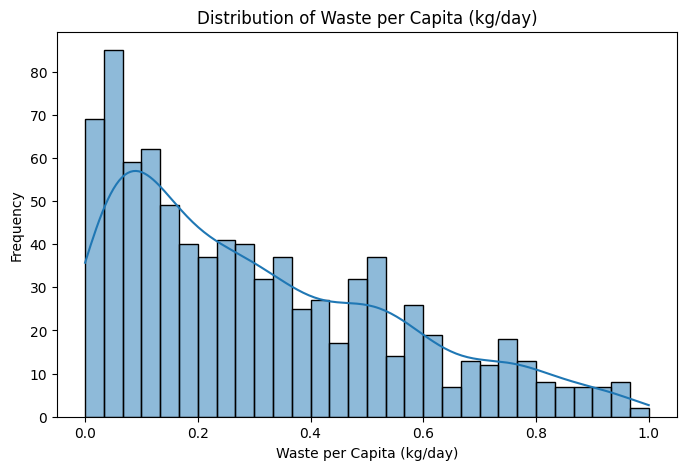

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# 1. Summary statistics
print("Summary statistics:")
print(merged_df.describe())

# 2. Distribution of Waste per Capita
plt.figure(figsize=(8,5))
sns.histplot(merged_df['Waste_per_capita'], bins=30, kde=True)
plt.title('Distribution of Waste per Capita (kg/day)')
plt.xlabel('Waste per Capita (kg/day)')
plt.ylabel('Frequency')
plt.show()




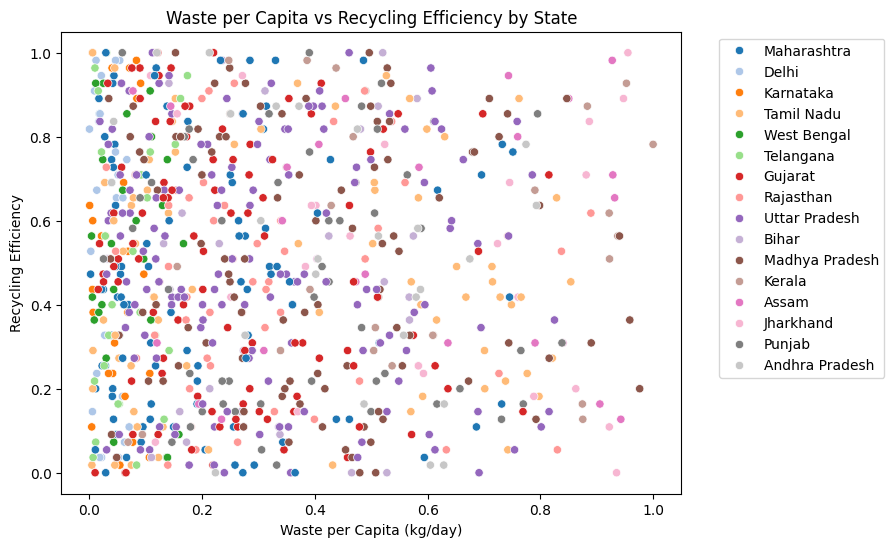

In [ ]:
# 3. Scatter plot: Waste per Capita vs Recycling Efficiency (colored by State)
plt.figure(figsize=(8,6))
sns.scatterplot(data=merged_df, x='Waste_per_capita', y='Recycling_Efficiency', hue='State', palette='tab20')
plt.title('Waste per Capita vs Recycling Efficiency by State')
plt.xlabel('Waste per Capita (kg/day)')
plt.ylabel('Recycling Efficiency')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()





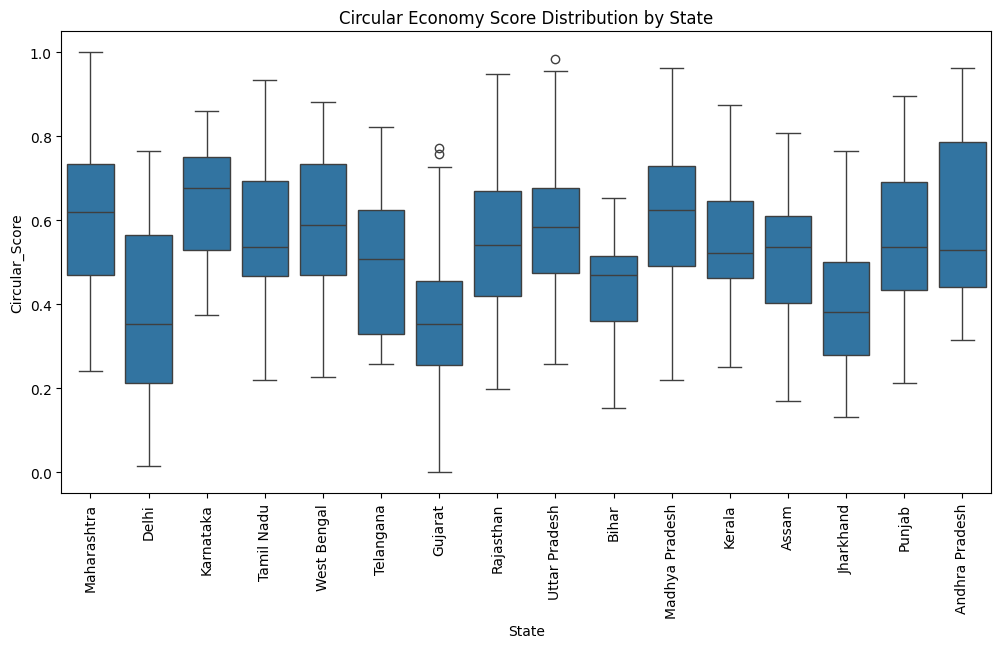

In [ ]:
# 4. Boxplot of Circular Score by State
plt.figure(figsize=(12,6))
sns.boxplot(data=merged_df, x='State', y='Circular_Score')
plt.xticks(rotation=90)
plt.title('Circular Economy Score Distribution by State')
plt.show()

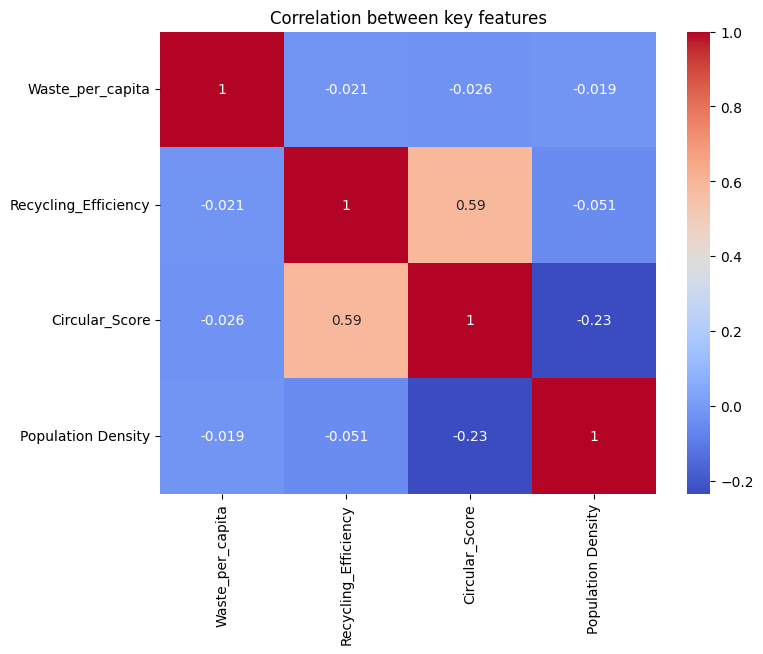

In [ ]:
# 5. Correlation heatmap for key features
plt.figure(figsize=(8,6))
corr = merged_df[['Waste_per_capita', 'Recycling_Efficiency', 'Circular_Score', 'Population Density']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation between key features')
plt.show()



In [ ]:
# 6. Interactive Plotly scatter: Waste per Capita vs Circular Score colored by SDG 12
fig = px.scatter(
    merged_df,
    x='Waste_per_capita',
    y='Circular_Score',
    color='SDG 12',
    hover_name='City_Name',
    title='Waste per Capita vs Circular Economy Score by SDG 12'
)
fig.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np

cities = merged_df['City_Name'].unique()
results = {}

for city in cities:
    city_data = merged_df[merged_df['City_Name'] == city].sort_values(by='Year')
    if city_data['Year'].nunique() < 5:
        print(f"❌ Not enough data to forecast for {city}")
        continue

    time_series = city_data[['Year', 'Waste Generated (Tons/Day)']].dropna()
    if len(time_series) < 4:  # at least window size + 1 data points
        print(f"❌ Not enough data points for {city}")
        continue

    scaler = MinMaxScaler()
    waste_scaled = scaler.fit_transform(time_series[['Waste Generated (Tons/Day)']])

    def create_sequences(data, window_size=3):
        X, y = [], []
        for i in range(len(data) - window_size):
            X.append(data[i:i+window_size])
            y.append(data[i+window_size])
        return np.array(X), np.array(y)

    X, y = create_sequences(waste_scaled, window_size=3)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    model = Sequential([
    Input(shape=(X.shape[1], 1)),  # <-- Add Input layer explicitly here
    LSTM(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=100, verbose=0)

    last_sequence = waste_scaled[-3:].reshape((1, 3, 1))
    next_prediction = model.predict(last_sequence)
    next_tpd = scaler.inverse_transform(next_prediction)[0][0]

    results[city] = next_tpd
    print(f"📈 Forecasted Waste for {city} (next year): {next_tpd:.2f} Tons/Day")

# Optional: convert results dict to DataFrame for saving or analysis
import pandas as pd
forecast_df = pd.DataFrame(list(results.items()), columns=['City_Name', 'Forecasted_Waste_TonsPerDay'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
📈 Forecasted Waste for Mumbai (next year): 6061.08 Tons/Day
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
📈 Forecasted Waste for Delhi (next year): 5556.22 Tons/Day
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
📈 Forecasted Waste for Bengaluru (next year): 4719.50 Tons/Day
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
📈 Forecasted Waste for Chennai (next year): 4512.31 Tons/Day


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
📈 Forecasted Waste for Kolkata (next year): 4047.00 Tons/Day


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
📈 Forecasted Waste for Hyderabad (next year): 3579.45 Tons/Day
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
📈 Forecasted Waste for Pune (next year): 5819.08 Tons/Day
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
📈 Forecasted Waste for Ahmedabad (next year): 4958.43 Tons/Day
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
📈 Forecasted Waste for Jaipur (next year): 5233.23 Tons/Day
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
📈 Forecasted Waste for Lucknow (next year): 5555.64 Tons/Day
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
📈 Forecasted Waste for Surat (next year): 5803.92 Tons/Day
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
📈 Forecasted Waste for Kanpur (next year): 5005.38 Tons/Day
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
📈 Forecasted Waste for Nagpur (next year): 4669.88 Tons/Day
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
📈 Forecasted Waste for Patna (next year): 4496.56 Tons/Day
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
📈 Forecasted Waste for Bhopal (next year): 5612.57 Tons/Day
1/1 ━━━

In [ ]:
ce_features = [
    'Recycling Rate (%)',
    'Municipal Efficiency Score (1-10)',
    'Awareness Campaigns Count',
    'Waste_TPD',  # from your dataset
    'SDG 12',
    'Waste_per_capita'
]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
✅ Silhouette Score (Overall Clustering Quality): 0.56


/tmp/ipython-input-19-1480003489.py:93: UserWarning:

Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.



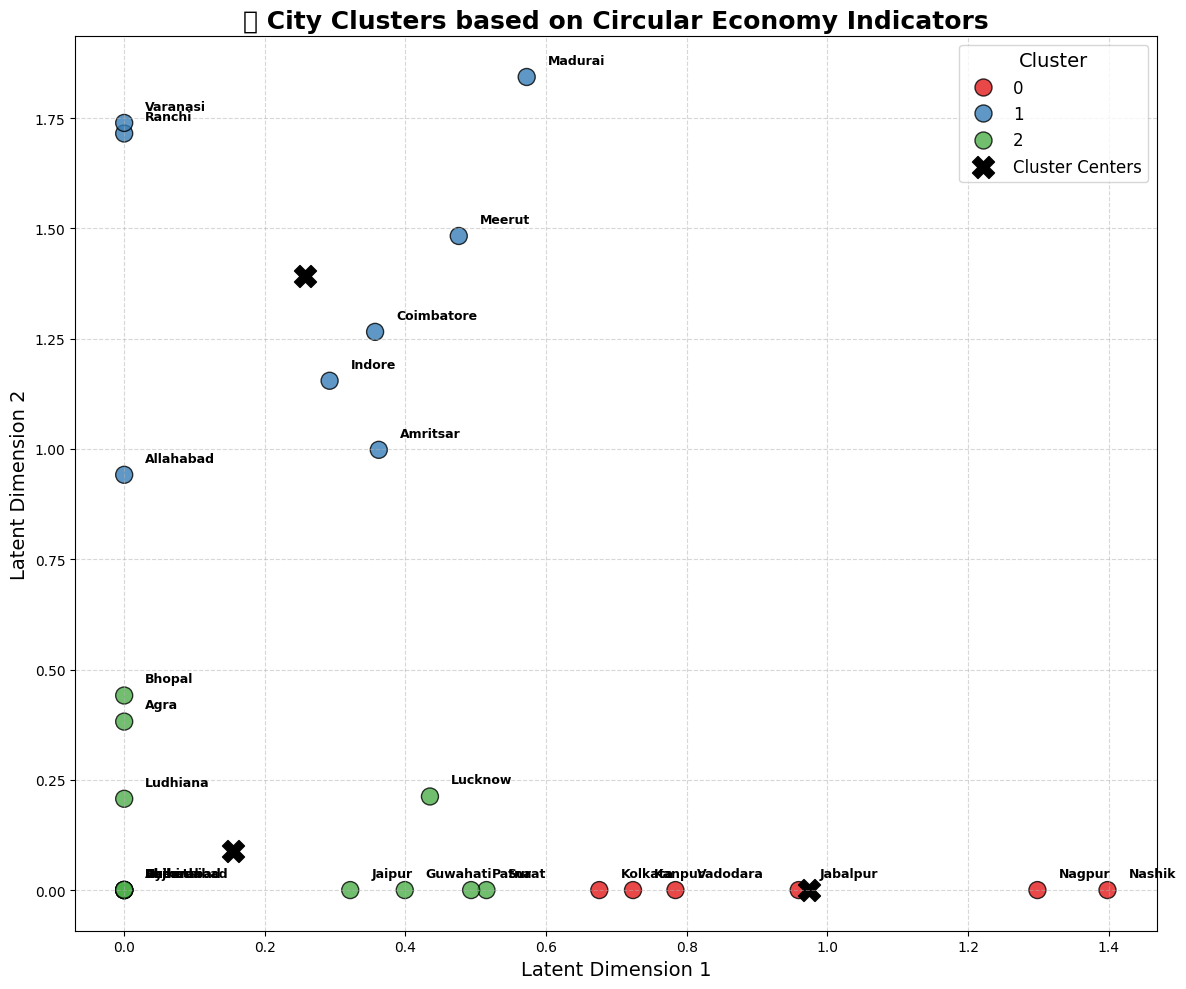

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
import seaborn as sns



# Drop duplicates so each city only once
ce_df = merged_df.drop_duplicates(subset='City_Name')

# Filter CE feature columns and drop rows with missing values
ce_data = ce_df[ce_features].dropna()

# Save city names corresponding to filtered rows
city_names = ce_df.loc[ce_data.index, 'City_Name'].values

# --- 2. Scale the features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(ce_data)

# --- 3. Build Autoencoder for Dimensionality Reduction ---
input_dim = X_scaled.shape[1]
encoding_dim = 2  # compress to 2D for visualization

input_layer = Input(shape=(input_dim,))
encoded = Dense(5, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(5, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder
autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=8, verbose=0)

# --- 4. Extract encoded features ---
X_encoded = encoder.predict(X_scaled)

# --- 5. Cluster in encoded space ---
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_encoded)

# --- 6. Silhouette score ---
silhouette_avg = silhouette_score(X_encoded, clusters)
print(f"✅ Silhouette Score (Overall Clustering Quality): {silhouette_avg:.2f}")

# Prepare DataFrame with embeddings and cluster info
encoded_df = pd.DataFrame(X_encoded, columns=['Dim1', 'Dim2'])
encoded_df['Cluster'] = clusters
encoded_df['City'] = city_names
encoded_df['Silhouette'] = silhouette_samples(X_encoded, clusters)

# --- 7. Visualization ---
plt.figure(figsize=(12, 10))
palette = sns.color_palette("Set1", n_colors=n_clusters)

sns.scatterplot(
    data=encoded_df,
    x='Dim1',
    y='Dim2',
    hue='Cluster',
    palette=palette,
    s=150,
    alpha=0.8,
    edgecolor='black'
)

# Plot cluster centers
centers = kmeans.cluster_centers_
plt.scatter(
    centers[:, 0], centers[:, 1],
    c='black', s=250, marker='X', label='Cluster Centers'
)

# Annotate city names with small offset
for i, row in encoded_df.iterrows():
    plt.text(row['Dim1'] + 0.03, row['Dim2'] + 0.03, row['City'], fontsize=9, weight='bold')

plt.title("🔄 City Clusters based on Circular Economy Indicators", fontsize=18, weight='bold')
plt.xlabel("Latent Dimension 1", fontsize=14)
plt.ylabel("Latent Dimension 2", fontsize=14)
plt.legend(title='Cluster', fontsize=12, title_fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



/tmp/ipython-input-20-1075552831.py:9: UserWarning:

Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.



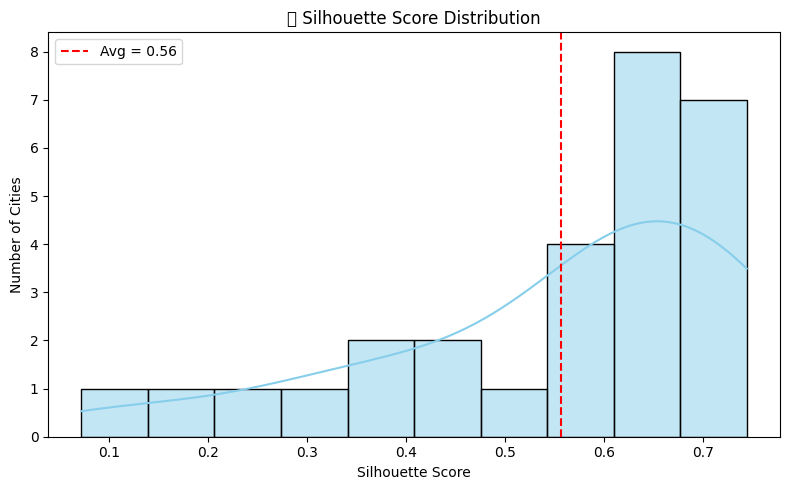


🔹 Cluster 0 (6 cities):
Kolkata, Kanpur, Nagpur, Vadodara, Nashik, Jabalpur

🔹 Cluster 1 (8 cities):
Indore, Coimbatore, Ranchi, Amritsar, Varanasi, Meerut, Madurai, Allahabad

🔹 Cluster 2 (14 cities):
Delhi, Chennai, Hyderabad, Pune, Ahmedabad, Jaipur, Lucknow, Surat, Patna, Bhopal, Guwahati, Ludhiana, Agra, Rajkot
✅ Saved: your_merged_ce_data.csv


In [ ]:
# === 8. Silhouette Distribution Plot ===
plt.figure(figsize=(8, 5))
sns.histplot(encoded_df['Silhouette'], bins=10, kde=True, color='skyblue')
plt.axvline(silhouette_avg, color='red', linestyle='--', label=f"Avg = {silhouette_avg:.2f}")
plt.title("📏 Silhouette Score Distribution")
plt.xlabel("Silhouette Score")
plt.ylabel("Number of Cities")
plt.legend()
plt.tight_layout()
plt.show()

# === 9. Cluster-wise City Summary ===
cluster_summary = encoded_df.groupby('Cluster')['City'].apply(list)
for c, cities in cluster_summary.items():
    print(f"\n🔹 Cluster {c} ({len(cities)} cities):")
    print(", ".join(cities))

merged_df.to_csv("your_merged_ce_data.csv", index=False)
print("✅ Saved: your_merged_ce_data.csv")

# === 10. Save cluster results ===
encoded_df.to_csv("city_clusters_autoencoder.csv", index=False)


In [ ]:
# Load cluster labels from saved CSV (from Phase 4)
cluster_df = pd.read_csv("city_clusters_autoencoder.csv")

# Confirm the column names in cluster_df
print(cluster_df.columns)


Index(['Dim1', 'Dim2', 'Cluster', 'City', 'Silhouette'], dtype='object')


In [ ]:
import pandas as pd

# Load your original merged CE dataset (adjust file path)
merged_df = pd.read_csv("your_merged_ce_data.csv")

# Load clustering results from autoencoder step (adjust file path)
cluster_df = pd.read_csv("city_clusters_autoencoder.csv")  # Has 'City', 'Cluster', etc.

# Merge cluster info with original CE dataset on city names
merged = pd.merge(
    merged_df,
    cluster_df[['City', 'Cluster']],
    left_on='City_Name',
    right_on='City',
    how='inner'
)

# If after merge you see duplicate cluster columns (Cluster_x, Cluster_y),
# keep 'Cluster_y' as final 'Cluster' and drop the rest
if 'Cluster_y' in merged.columns and 'Cluster_x' in merged.columns:
    merged['Cluster'] = merged['Cluster_y']
    merged.drop(columns=['Cluster_x', 'Cluster_y'], inplace=True)

# Define CE action mapping based on cluster label
action_map = {
    0: 'Rethink',
    1: 'Redesign',
    2: 'Reuse'
}

# Map cluster to CE Action
merged['CE_Action'] = merged['Cluster'].map(action_map)

# Show sample output
print(merged[['City_Name', 'Cluster', 'CE_Action']].head(10))

# Save final dataframe with CE action recommendations
merged.to_csv("ce_action_recommendations.csv", index=False)
print("✅ Saved: ce_action_recommendations.csv")


  City_Name  Cluster CE_Action
0     Delhi        0   Rethink
1     Delhi        0   Rethink
2     Delhi        0   Rethink
3     Delhi        0   Rethink
4     Delhi        0   Rethink
5     Delhi        0   Rethink
6     Delhi        0   Rethink
7     Delhi        0   Rethink
8     Delhi        0   Rethink
9     Delhi        0   Rethink
✅ Saved: ce_action_recommendations.csv


/tmp/ipython-input-49-1996795105.py:38: UserWarning:

Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.



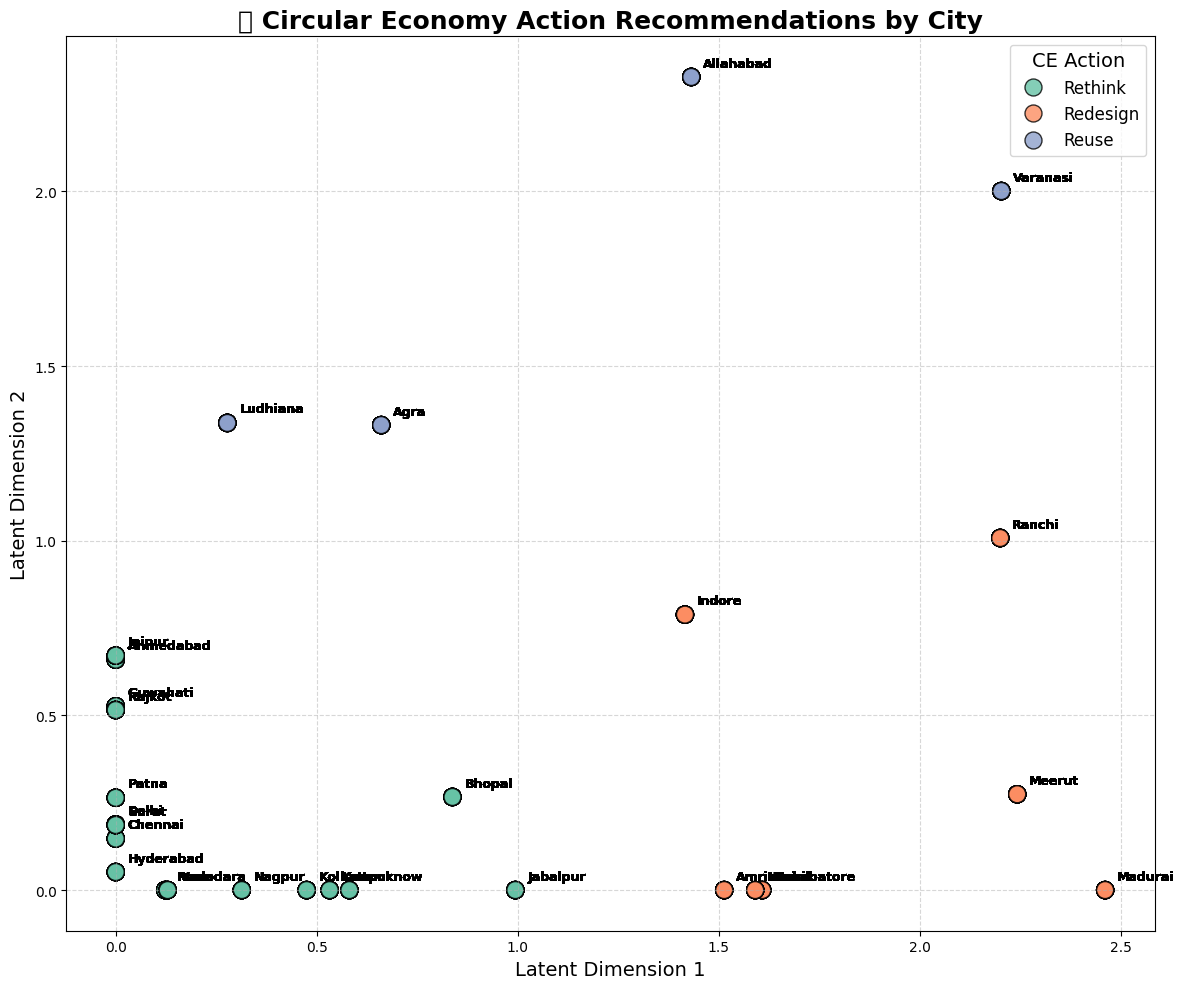

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# If 'Dim1' and 'Dim2' are missing, merge from cluster_df
if 'Dim1' not in merged.columns or 'Dim2' not in merged.columns:
    merged = merged.merge(
        cluster_df[['City', 'Dim1', 'Dim2']],
        left_on='City_Name',
        right_on='City',
        how='left'
    )

plt.figure(figsize=(12, 10))

# Use a distinct color palette for the CE_Action categories
palette = sns.color_palette("Set2", n_colors=3)

sns.scatterplot(
    data=merged,
    x='Dim1',
    y='Dim2',
    hue='CE_Action',
    palette=palette,
    s=150,
    edgecolor='black',
    alpha=0.8
)

# Annotate city names slightly offset
for i, row in merged.iterrows():
    plt.text(row['Dim1'] + 0.03, row['Dim2'] + 0.03, row['City_Name'], fontsize=9, weight='bold')

plt.title("🔄 Circular Economy Action Recommendations by City", fontsize=18, weight='bold')
plt.xlabel("Latent Dimension 1", fontsize=14)
plt.ylabel("Latent Dimension 2", fontsize=14)
plt.legend(title='CE Action', fontsize=12, title_fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Select features and target
features = [
    'Recycling Rate (%)',
    'Population Density',
    'Municipal Efficiency Score (1-10)',
    'Cost of Waste Management (₹/Ton)',
    'Awareness Campaigns Count',
    'Landfill Capacity (Tons)',
    'Waste_TPD',
    'Waste_per_capita',
    'Total_Population',
    'SDG 12',
    'Composite Score',
    'Recycling_Efficiency',
    'Circular_Score'
]

X = merged[features].copy()
y = merged['CE_Action']

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Rethink:0, Redesign:1, Reuse:2

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report, accuracy_score

models = []
names = ['MLP_1layer', 'MLP_2layer', 'Dropout_MLP', 'BatchNorm_MLP', 'WideDeep_MLP']
histories = []
scores = []

for name in names:
    model = Sequential()
    model.add(Dense(64, input_shape=(X_train_scaled.shape[1],), activation='relu'))

    if name == 'MLP_2layer':
        model.add(Dense(32, activation='relu'))

    elif name == 'Dropout_MLP':
        model.add(Dropout(0.3))
        model.add(Dense(32, activation='relu'))

    elif name == 'BatchNorm_MLP':
        model.add(BatchNormalization())
        model.add(Dense(32, activation='relu'))

    elif name == 'WideDeep_MLP':
        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))

    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=8, verbose=0, validation_split=0.2)

    y_pred = model.predict(X_test_scaled)
    y_pred_labels = y_pred.argmax(axis=1)

    acc = accuracy_score(y_test, y_pred_labels)
    scores.append(acc)
    models.append(model)
    histories.append(history)

    print(f"\n🔍 Model: {name}")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred_labels, target_names=le.classes_))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

🔍 Model: MLP_1layer
Accuracy: 0.9143
              precision    recall  f1-score   support

    Redesign       0.80      0.91      0.85        35
     Rethink       0.95      0.91      0.93        85
       Reuse       1.00      0.95      0.97        20

    accuracy                           0.91       140
   macro avg       0.92      0.92      0.92       140
weighted avg       0.92      0.91      0.92       140



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

🔍 Model: MLP_2layer
Accuracy: 0.9143
              precision    recall  f1-score   support

    Redesign       0.85      0.94      0.89        35
     Rethink       0.96      0.89      0.93        85
       Reuse       0.86      0.95      0.90        20

    accuracy                           0.91       140
   macro avg       0.89      0.93      0.91       140
weighted avg       0.92      0.91      0.91       140



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

🔍 Model: Dropout_MLP
Accuracy: 0.9786
              precision    recall  f1-score   support

    Redesign       0.95      1.00      0.97        35
     Rethink       0.99      0.98      0.98        85
       Reuse       1.00      0.95      0.97        20

    accuracy                           0.98       140
   macro avg       0.98      0.98      0.98       140
weighted avg       0.98      0.98      0.98       140



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

🔍 Model: BatchNorm_MLP
Accuracy: 0.8714
              precision    recall  f1-score   support

    Redesign       0.82      0.91      0.86        35
     Rethink       0.94      0.85      0.89        85
       Reuse       0.75      0.90      0.82        20

    accuracy                           0.87       140
   macro avg       0.84      0.89      0.86       140
weighted avg       0.88      0.87      0.87       140



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

🔍 Model: WideDeep_MLP
Accuracy: 0.9357
              precision    recall  f1-score   support

    Redesign       0.87      0.97      0.92        35
     Rethink       0.97      0.92      0.95        85
       Reuse       0.90      0.95      0.93        20

    accuracy                           0.94       140
   macro avg       0.92      0.95      0.93       140
weighted avg       0.94      0.94      0.94       140



In [ ]:
best_idx = scores.index(max(scores))
best_model = models[best_idx]
print(f"\n✅ Best Model: {names[best_idx]} with Accuracy: {scores[best_idx]:.4f}")



✅ Best Model: Dropout_MLP with Accuracy: 0.9786


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
📊 F1 Score (macro): 0.9763


/tmp/ipython-input-41-3134291662.py:26: UserWarning:

Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.



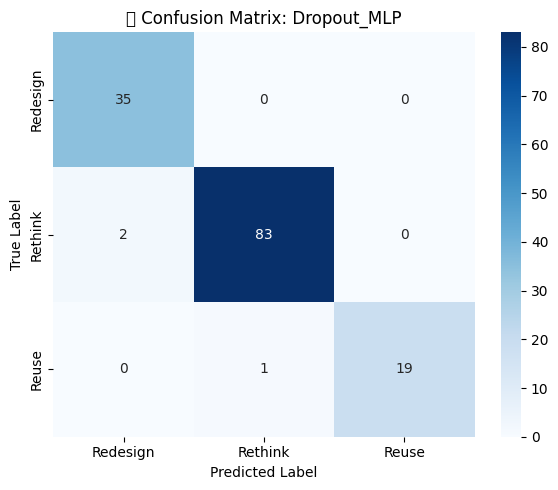

📈 ROC-AUC (OvR): 0.9994


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

# Get the trained Dropout_MLP model (assuming it's at index 2)
dropout_model = models[names.index('Dropout_MLP')]

# Predict
y_pred_probs = dropout_model.predict(X_test_scaled)
y_pred_labels = y_pred_probs.argmax(axis=1)

# === F1 Score ===
f1_macro = f1_score(y_test, y_pred_labels, average='macro')
print(f"📊 F1 Score (macro): {f1_macro:.4f}")

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("🔍 Confusion Matrix: Dropout_MLP")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# === ROC-AUC (One-vs-Rest) ===
# Binarize y_test for multi-class ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

try:
    auc_ovr = roc_auc_score(y_test_bin, y_pred_probs, multi_class='ovr')
    print(f"📈 ROC-AUC (OvR): {auc_ovr:.4f}")
except ValueError:
    print("⚠️ ROC-AUC could not be computed due to class imbalance or missing classes in y_test.")


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━

PermutationExplainer explainer:   4%|▍         | 2/50 [00:00<?, ?it/s]

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:   8%|▊         | 4/50 [00:29<04:08,  5.40s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  10%|█         | 5/50 [00:33<03:41,  4.92s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  12%|█▏        | 6/50 [00:39<03:45,  5.13s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  14%|█▍        | 7/50 [00:43<03:20,  4.66s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  16%|█▌        | 8/50 [00:47<03:07,  4.47s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  18%|█▊        | 9/50 [00:52<03:14,  4.74s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  20%|██        | 10/50 [00:56<03:01,  4.53s/it]

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  22%|██▏       | 11/50 [01:00<02:52,  4.43s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  24%|██▍       | 12/50 [01:06<02:58,  4.70s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  26%|██▌       | 13/50 [01:10<02:44,  4.45s/it]

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  28%|██▊       | 14/50 [01:13<02:34,  4.28s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  30%|███       | 15/50 [01:19<02:41,  4.61s/it]

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  32%|███▏      | 16/50 [01:23<02:32,  4.47s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  34%|███▍      | 17/50 [01:29<02:41,  4.88s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  36%|███▌      | 18/50 [01:34<02:41,  5.05s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  38%|███▊      | 19/50 [01:38<02:27,  4.76s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  40%|████      | 20/50 [01:43<02:26,  4.88s/it]

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  42%|████▏     | 21/50 [01:48<02:18,  4.76s/it]

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  44%|████▍     | 22/50 [01:52<02:07,  4.56s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  46%|████▌     | 23/50 [01:58<02:11,  4.86s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  48%|████▊     | 24/50 [02:02<02:02,  4.72s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  50%|█████     | 25/50 [02:06<01:51,  4.46s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  52%|█████▏    | 26/50 [02:11<01:53,  4.71s/it]

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  54%|█████▍    | 27/50 [02:15<01:41,  4.42s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  56%|█████▌    | 28/50 [02:19<01:35,  4.33s/it]

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  58%|█████▊    | 29/50 [02:24<01:36,  4.60s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  60%|██████    | 30/50 [02:28<01:29,  4.47s/it]

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  62%|██████▏   | 31/50 [02:33<01:23,  4.41s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  64%|██████▍   | 32/50 [02:38<01:23,  4.64s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  66%|██████▌   | 33/50 [02:42<01:16,  4.51s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  68%|██████▊   | 34/50 [02:46<01:10,  4.39s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  70%|███████   | 35/50 [02:52<01:11,  4.75s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  72%|███████▏  | 36/50 [02:56<01:03,  4.57s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  74%|███████▍  | 37/50 [03:00<00:57,  4.43s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  76%|███████▌  | 38/50 [03:05<00:56,  4.72s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  78%|███████▊  | 39/50 [03:10<00:50,  4.59s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  80%|████████  | 40/50 [03:14<00:44,  4.44s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  82%|████████▏ | 41/50 [03:19<00:42,  4.72s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  84%|████████▍ | 42/50 [03:23<00:35,  4.50s/it]

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  86%|████████▌ | 43/50 [03:27<00:31,  4.45s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  88%|████████▊ | 44/50 [03:33<00:28,  4.78s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  90%|█████████ | 45/50 [03:38<00:23,  4.69s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  92%|█████████▏| 46/50 [03:42<00:18,  4.55s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  94%|█████████▍| 47/50 [03:47<00:14,  4.79s/it]

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  96%|█████████▌| 48/50 [03:51<00:09,  4.54s/it]

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  98%|█████████▊| 49/50 [03:55<00:04,  4.44s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer: 100%|██████████| 50/50 [04:01<00:00,  4.72s/it]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer: 51it [04:07,  5.04s/it]
/tmp/ipython-input-43-4008263907.py:8: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



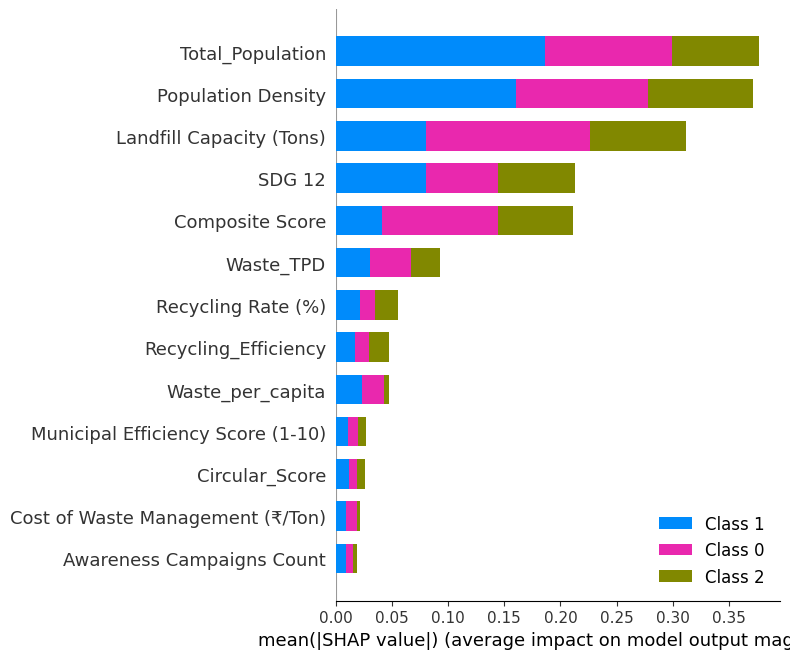

In [ ]:
import shap

# Use SHAP KernelExplainer
explainer = shap.Explainer(best_model.predict, X_test_scaled)
shap_values = explainer(X_test_scaled[:50])  # Use a subset for speed

# SHAP summary plot
shap.summary_plot(shap_values, X_test.iloc[:50], feature_names=features)


/tmp/ipython-input-44-1472516604.py:29: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.

/tmp/ipython-input-44-1472516604.py:29: UserWarning:

Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.



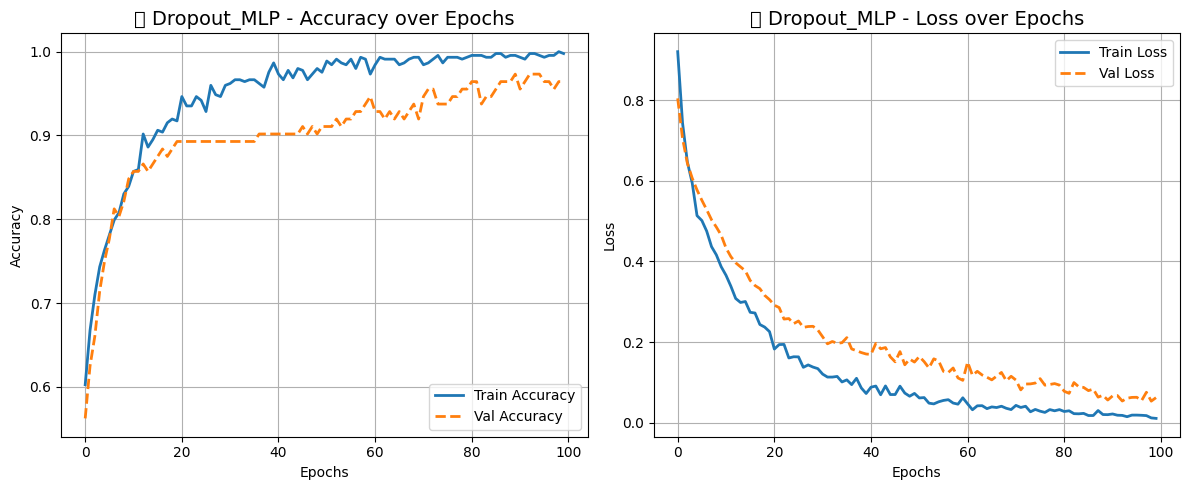

In [ ]:
import matplotlib.pyplot as plt

# Get the training history for Dropout_MLP (index 2)
history = histories[names.index('Dropout_MLP')]

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# --- Accuracy Plot ---
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2, linestyle='--')
plt.title('📈 Dropout_MLP - Accuracy over Epochs', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# --- Loss Plot ---
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2, linestyle='--')
plt.title('📉 Dropout_MLP - Loss over Epochs', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
